In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [3]:
#some helper function image processing
#  nice refreshing 
# https://stackoverflow.com/questions/49732726/how-to-compute-the-gradients-of-image-using-python
# return image to gray scale 
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
# return image info
def imageInfo(img):
    X_size = img.shape[1]
    Y_size = img.shape[0]
    print("image type is: ",type(img),"\n Xsize is: ",X_size,"\n Ysize is: ",Y_size)

In [5]:
# return GaussianMasked image, square kernel
def gaussianMask(img,kernel_size):
    if kernel_size == 0 :
        return img
    # Define agaussianMask kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    masked = cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)
    return masked

In [6]:
def erosion(image,erosion_size):
    erosion_shape = cv2.MORPH_RECT
    element = cv2.getStructuringElement(erosion_shape, (2 * erosion_size + 1, 2 * erosion_size + 1),(erosion_size, erosion_size))
    erosion_dst = cv2.erode(image, element)
    return erosion_dst

In [7]:
# return colorMask color_threshold, easier for combined with other thresholds to do boolean operation
def colorMask(img,threshold):
# Define our color selection criteria
# Note: if you run this code, you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz
    red_threshold = threshold
    green_threshold = threshold
    blue_threshold = threshold
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Do a boolean or with the "|" character to identify pixels below the thresholds
    color_thresholds = (image[:,:,0] < rgb_threshold[0])|(image[:,:,1] < rgb_threshold[1])|(image[:,:,2] < rgb_threshold[2])
    # color_select[thresholds] = [0,0,0]
    # image[:,:,0] < rgb_threshold[0] will provide a boolean matrix with value smaller than threshold being true and larger being false
    # when apply image[threshold_1,threshold_2,threshold_3] = 255 only true position will be replaced with the 255
    # # Display the image                 
    # plt.imshow(color_select)
    # plt.show()
    return color_thresholds

In [8]:
# return RegionMask region_thresholds, easier for combined with other thresholds to do boolean operation
def triangle_regionMask(img,edgeFactor,apexFactor):
    # Define a triangle region of interest 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing
    ysize = img.shape[0]
    xsize = img.shape[1]
    left_bottom = [0, ysize*edgeFactor]
    right_bottom = [xsize*edgeFactor, ysize*edgeFactor]
    apex = [xsize*apexFactor, ysize*apexFactor]
    
    # Fit lines (y=Ax+B) to identify the  3 sided region of interest
    # np.polyfit() returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))

    # Color pixels black which are outside the region of interest
#     img[~region_thresholds] = [0, 0, 0]
    return region_thresholds

In [9]:
# return RegionMask region_thresholds, easier for combined with other thresholds to do boolean operation
def polygon_regionMask(edges,ratio, shift):
    imshape = edges.shape
    vertices = np.array([[(0,imshape[0]),(ratio*imshape[1]-shift, ratio*imshape[0]+shift), (ratio*imshape[1]+shift, ratio*imshape[0]+shift), (imshape[1],imshape[0])]], dtype=np.int32)
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges,mask)
    return masked_edges,vertices

In [10]:
#some helper function computer vision
# Canny requires gray image, threshold raion to be 1:2 or 1:3
def canny(gray,low_threshold,high_threshold):
    edges = cv2.Canny(gray,low_threshold,high_threshold) 
    return edges

In [11]:
# get distance from one point(P(x,y)) to a line(A(x,y),B(x,y)) 
# NOT USED
def getDist_P2L(pointP,pointA,pointB):
    A = pointA[1] - pointB[1]
    B = pointA[0] - pointB[0]
    C = pointA[0] * pointB[1] - pointA[1] * pointB[0]
    distance = (np.abs(A*pointP[0] + B*pointP[1] + C))/(np.sqrt(A*A + B*B))
    n = np.append(distance,10)
    print(n)
    return distance

In [12]:
#  get distance point to point
def getDist_P2P(pointA,pointB):
    pA_x = pointA[0]
    pA_y = pointA[1]
    pB_x = pointB[0]
    pB_y = pointB[1]
#     print("from getDist_P2P ", type(pA_x),pA_x, 10*pA_x)
    return np.sqrt((pA_x-pB_x)*(pA_x-pB_x) + (pA_y-pB_y)*(pA_y-pB_y))

In [46]:
# get hough space point for a line in image space
# to solve rho,t_idx, rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
def getHough_Point(pointA_x,pointA_y,pointB_x,pointB_y):
    tan_idx = -1*(pointA_x-pointB_x)/(pointA_y-pointB_y)
    rad_idx = np.arctan(tan_idx)
    diag_len = np.sqrt(540*540 + 960*960)
    rho_idx = pointA_x*np.cos(rad_idx) + pointA_y*np.sin(rad_idx) + diag_len
    x = rho_idx * np.cos(rad_idx)
    y = rho_idx * np.sin(rad_idx)
    return x,y
#     return rad_idx, rho_idx

In [144]:
# create distance matrix to help for merge lines 
def mergeLines(lines,threshold):
#     distance_map stores distance b/t two lines distance in hough space
    distance_map = np.zeros(shape = (len(lines),len(lines)))
#     cluster_map stores the index of other line that below the threshold 
    cluster_map = np.zeros(shape = (len(lines),len(lines)))
#     cluster_comparison stores the sum of all the points within threshold to the points
    cluster_comparison = np.zeros(shape = (1,len(lines)))
#     hough_P stores all hough points
    houghP = np.zeros(shape = (len(lines),1,2))
#     quality_ctr to make sure a line has decent amount of cluster
    quality_ctr = 0
    quality_ctr_limit = 3
    loop_length = len(lines)
    for i in range(loop_length):
        if i >= loop_length:
            break
#         print("from MergeLines->i ",i, loop_length, type(i))
        HoughP_A = getHough_Point(lines[i][:,0],lines[i][:,1],lines[i][:,2],lines[i][:,3])
        houghP[i] = [getHough_Point(lines[i][:,0],lines[i][:,1],lines[i][:,2],lines[i][:,3])]
        quality_ctr = 0
        
        for j in range (len(lines)):
            HoughP_B = getHough_Point(lines[j][:,0],lines[j][:,1],lines[j][:,2],lines[j][:,3])
            distance = getDist_P2P(HoughP_A, HoughP_B)
            distance_map[i][j] = distance 
            if distance < threshold : 
                cluster_comparison[:,i] = cluster_comparison[:,i] + distance
                cluster_map[i][j] = j
                quality_ctr += 1
        if (quality_ctr < quality_ctr_limit):
#             if too small cluster than increate 1000 times to make it 
            i = i-1
            cluster_comparison = np.delete(cluster_comparison,i,1)
            distance_map = np.delete(distance_map,i,0)
            cluster_map = np.delete(cluster_map,i,0)
            houghP = np.delete(houghP,i,0)
#             print("from MergeLInes after: ", cluster_comparison.shape, distance.shape, cluster_map.shape, houghP.shape)
            loop_length -=1
                
    return distance_map, cluster_comparison, cluster_map, houghP        

In [145]:
# sort function will sort the array as assending order
# implementing quick_sort mechanism
def quick_sort(array):
#     edge case 1 no/only 1 element
    if len(array)<2:
        return np.array(array)
#     change array type to int by scale 1000 times and convert back after all finished

#     Initialize place holder
    pivot = array[-1]
    total_len = len(array)
    left = []
    middle = []
    right = []
    left_index = []
    middle_index = []
    right_index = []
    index_array = [*range(0,total_len)]# use * to unpack the array 
    counter = []
    hist_right = 0
    shift = 0

#     main loop to accumulate "array"
    while len(counter) < total_len:
        for i in range(total_len):
            if array[i] < pivot:
                left = left +[array[i]]
                left_index = left_index + [index_array[i]]
            elif array[i] > pivot:
                right = right + [array[i]]
                right_index = right_index + [index_array[i]]
            else:
                middle = middle + [array[i]]
                middle_index = middle_index + [index_array[i]]
#     Assemble array for each pass             
        array = left + middle + right
        index_array = left_index + middle_index + right_index
#     update shift and also check edge case 2 all element are same
        if len(right) == hist_right and len(middle)!= total_len:
            shift = len(middle) + len(right)
#     update the counter only if when we need to update shift 
            counter= counter + middle
#     adjust shift when the pivot is the smallest, hence no need to shift 
            if len(middle) + len(right) == total_len:
                shift = shift - 1
#     update pivot per shift, update hist_right and counter for last run
        pivot = array[-1 - shift]
        hist_right = len(right)
#     clear left right middle place holder
        left = []
        right = []
        middle = []
        left_index = []
        middle_index = []
        right_index = []
# return the sorted array and the orignal index referring to the input array
# the index is used as a map to find the corresponding hough lines based on the sorted array 
    return np.array(array),np.array(index_array)

In [146]:
# compare and check how many points overlaped between two arrays 
def compare_2_array(arrayA, arrayB):
    counter = 0
    for i in range(len(arrayA)):
        for j in range(len(arrayB)):
# if need to use arrayA[i].any() == arrayB[j].any() in any operands, that means the arrays in both side is not the same shape
            if arrayA[i] != 0 and arrayA[i] == arrayB[j] :
                counter +=1
    return counter

In [153]:
# Hough Transform(line)
def hough(masked_edges, rho, theta, threshold, min_line_length, max_line_gap):
    # rho distance resolution in pixels in hough grid
    theta = theta * np.pi/180   # angular resolution in radians of the Hough grid
    # threshold minimum number of votes( intersection in hough grid)
    # minimum number of pixels making up a line
    # maximum gap in pixels between connectable line segments
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    original_houghLine = lines
    # prepare color_edges by duplicate masked_edges    
    color_edges = np.dstack((masked_edges,masked_edges,masked_edges))
#     print("from hough-> color_edges type:", type(color_edges[0][0][0]))
    # creating a blank to draw lines on
    line_image = np.copy(color_edges)*0 
    mono_line = np.copy(masked_edges)*0
#     print(line_image.shape)
    [distance_map, cluster_comparison, cluster_map, houghPoint] = mergeLines(lines,500)
    [sorted_cluster,cluster_index] = quick_sort(cluster_comparison[0])
#     B = quick_sort(clusters_comparison[0])
#     print("from hough -> compare quality ctr effect: ", lines.shape, distance_map.shape)
#     print("from hough -> distance_map\n",distance_map)
#     print("from hough -> cluster_map\n",cluster_map,cluster_map.shape)
#     print("from hough -> cluster_comparison\n",cluster_comparison,cluster_comparison.shape)
#     print("from hough -> sorted_cluster\n",sorted_cluster,sorted_cluster.shape)
#     print("from hough -> sorted_cluster\n",cluster_index,cluster_index.shape)
    final_index = []
    unique_cluster = np.array([])
    overlap_threshold = 3
#     Note : clusters are sorted based on the distance from one point to rest point within threshold, did not threshold minimum number of points
    for i in range(len(sorted_cluster)):
        unique_signal = 0
        j = 0
        if i == 0:
            final_index.append([cluster_index[i]])
            unique_cluster = np.vstack([cluster_map[i,:]])
#             print("in side hough comapre cluster loop: \n",cluster_index[i], cluster_map[i,:])
        while j<len(final_index):
            if compare_2_array(cluster_map[i,:],unique_cluster[j])>overlap_threshold:
                unique_signal +=1
            j+=1
        if unique_signal == 0:
            final_index.append([cluster_index[i]])
            unique_cluster = np.vstack((unique_cluster, cluster_map[i,:]))
#             print("in side hough comapre cluster loop: \n",cluster_index[i], cluster_map[i,:])

    # Iterate over the output "lines" and draw lines on a blank image
#     print("from hough-> final index/unique_cluster \n",final_index, unique_cluster)
#     print(lines.shape,lines[0])
    final_line = np.empty((len(final_index),1,4),dtype = np.int16)
    for i in range(len(final_index)):
        final_line[i] = lines[final_index[i]]
#         print("from final_line loop", final_index[i])
#     print("from hough:",houghPoint,final_line.shape,final_line)

    #   plot some scatter of the hough points 
#     print("houghPoint plot")
    fig0 = plt.figure(figsize = (10,7))
    fig,ax = plt.subplots()
    for i in houghPoint:
        ax.scatter(i[0][0],i[0][1])
    plt.imshow
    plt.title("hough space plot")
    
    return final_line, original_houghLine

In [148]:
#  find top_left,bot_left,bot_right,top_right corner point from original_houghLine
def find_corner_point(lines,width):
#     assign some values to corner point
#     left line AB, right line CD, from bottom left clock-wise A-B-C-D
    left_x_A = lines[0][0][0]
    left_y_A = lines[0][0][1]
#     left_x_B, right_x_C need proper initial value
    left_x_B = 0
    left_y_B = 0
    right_x_C = width
    right_y_C = 0
    right_x_D = lines[0][0][2]
    right_y_D = lines[0][0][3]
    for line in lines:
        x1 = line[0][0]
        y1 = line[0][1]
        x2 = line[0][2]
        y2 = line[0][3]
#         print("from find_corner_point:", x1,y1,x2,y2)
        if x1 < width*0.5 and x2 < width*0.5:
            if x1 < left_x_A:
                left_x_A = x1
                left_y_A = y1
            if x2 > left_x_B:
                left_x_B = x2
                left_y_B = y2
        if x1 > width*0.5 and x2 > width*0.5:
            if x1 < right_x_C:
                right_x_C = x1
                right_y_C = y1
            if x2 > right_x_D:
                right_x_D = x2
                right_y_D = y2
    return [[left_x_A,left_y_A,left_x_B,left_y_B]],[[right_x_C,right_y_C,right_x_D,right_y_D]]
    

In [149]:
def create_line_image(image,lines):
#     convert image type to uint8
    line_image = np.copy(image)*0 
#     i = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
#             print(x1,y1,x2,y2,"x,y",type(x1))
            color = np.random.randint(0, 255, size=(3, ))
#             print("from create_line_image:",color)
            cv2.line(line_image,(int(x1),int(y1)),(int(x2),int(y2)),(int(color[0]),int(color[1]),int(color[2])),10)
#             if i%2==0:
#                 cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
#             else :
#                 cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),10)
    return line_image

In [150]:
# return the intersections between line and polygon and inside the polygon
def find_intersection(polygon_vertices,lines):
    Y_top = polygon_vertices[0][1][1]
    Y_bot = polygon_vertices[0][3][1]
    newline = []
#     print("from find_intersection ",lines.shape,polygon_vertices.shape)
    for i in range(len(lines)):
        x1 = lines[i][0][0]
        y1 = lines[i][0][1]
        x2 = lines[i][0][2]
        y2 = lines[i][0][3]
        K = (y1-y2)/(x1-x2)
        B = (x1*y2-y1*x2)/(x1-x2)
#         if (K<0.001):
#             K = 0.001
        X_top = (Y_top-B)/K
        X_bot = (Y_bot-B)/K
        lines[i][0][0] = X_top
        lines[i][0][1] = Y_top
        lines[i][0][2] = X_bot
        lines[i][0][3] = Y_bot
    return lines

In [151]:
# program that contains the pipeline
def process_image(image, hough_cluster_method, use_video):
    # Basic computer vision techniques
    blur = gaussianMask(image,0)
    erosion_image = erosion(blur,0)
    gray = grayscale(erosion_image)
    [ysize,xsize] = gray.shape
    blur_gray = gaussianMask(gray,3)
    edges = canny(blur_gray,150,300)
    [masked_edges,polygon_vertices] = polygon_regionMask(edges,0.5,80)
    [hough_lines,original_hough_lines] = hough(masked_edges,1,1,10,10,1)
    if hough_cluster_method:
#         hough_lines = find_intersection(polygon_vertices,hough_lines)
        pass
    else:
        [ysize,xsize] = gray.shape
        hough_lines = find_corner_point(original_hough_lines,xsize)
        hough_lines = find_intersection(polygon_vertices,hough_lines)
#     print("from process_image ",hough_lines.shape)
#     print("from process_image",hough_lines.shape)
    line_image = create_line_image(image,hough_lines)
    combine_image = cv2.addWeighted(image,0.8,line_image,2,0)
    if not use_video: 
        fig1 = plt.figure(figsize=(60,43))
        fig1.add_subplot(6,1,1)
        plt.imshow(image)
        plt.title("original image")
        fig1.add_subplot(6,1,2)
        plt.imshow(blur_gray,cmap = "Greys_r")
        plt.title("gray->blur image")
        fig1.add_subplot(6,1,3)
        plt.imshow(masked_edges,cmap = "Greys_r")
        plt.title("canny edge and masked with polygon region")
        fig1.add_subplot(6,1,4)
        plt.imshow(combine_image)
        plt.title("hough transform showing all image")
#         fig1.add_subplot(6,1,1)
#         plt.imshow(masked_edges,cmap = "Greys_r")
#         plt.title("with erosions")
#         fig1.add_subplot(6,1,2)
#         plt.imshow(masked_edges,cmap = "Greys_r")
#         plt.title("canny->polygon_masked")
#         fig2 = plt.figure(figsize=(10,7))
#         plt.imshow(combine_image)
#         plt.title("combined image")
#         plt.title("gray->blur->canny"),plt.xticks([]), plt.yticks([])
    return combine_image

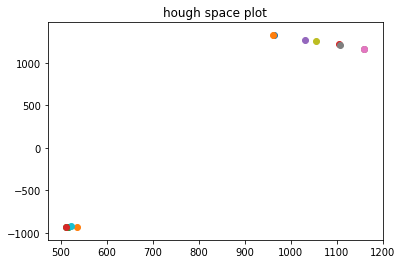

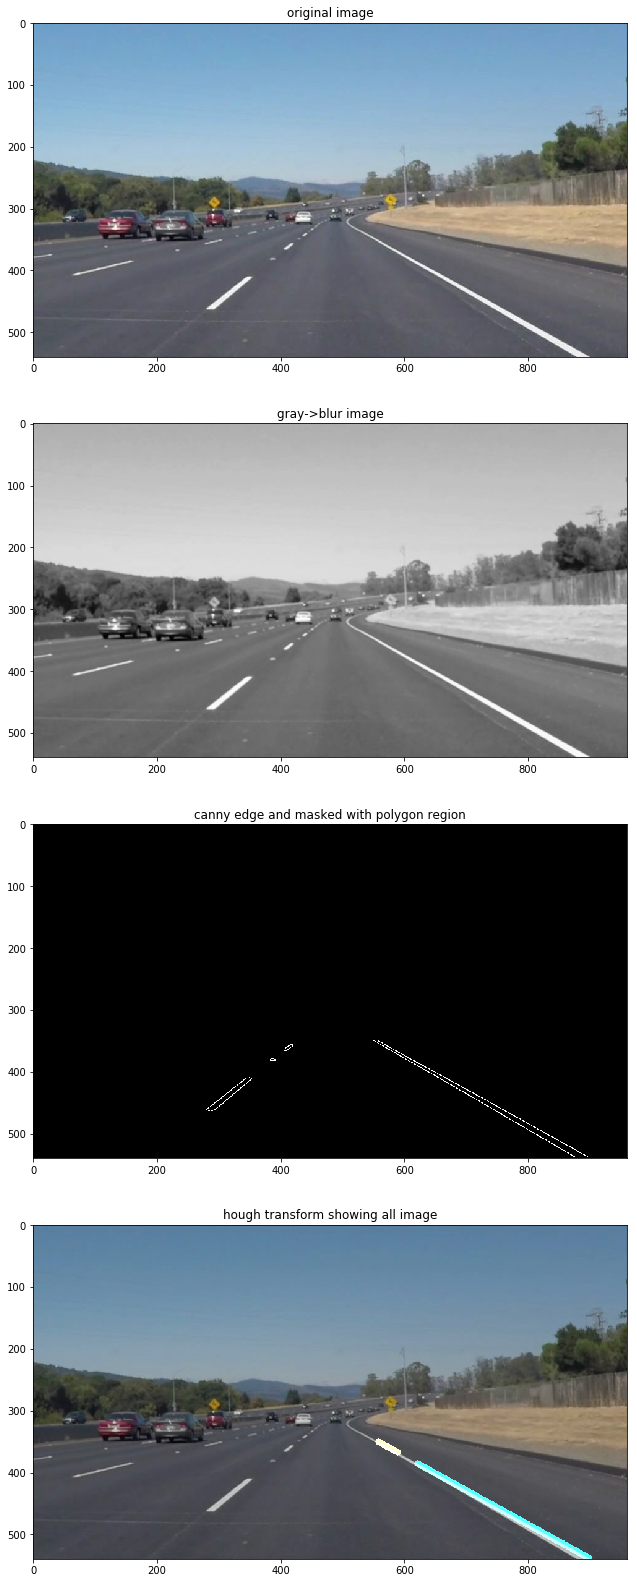

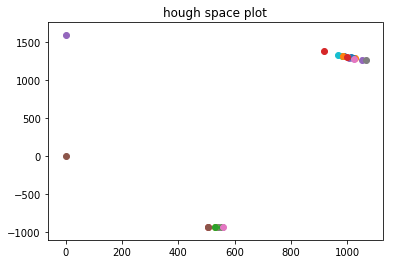

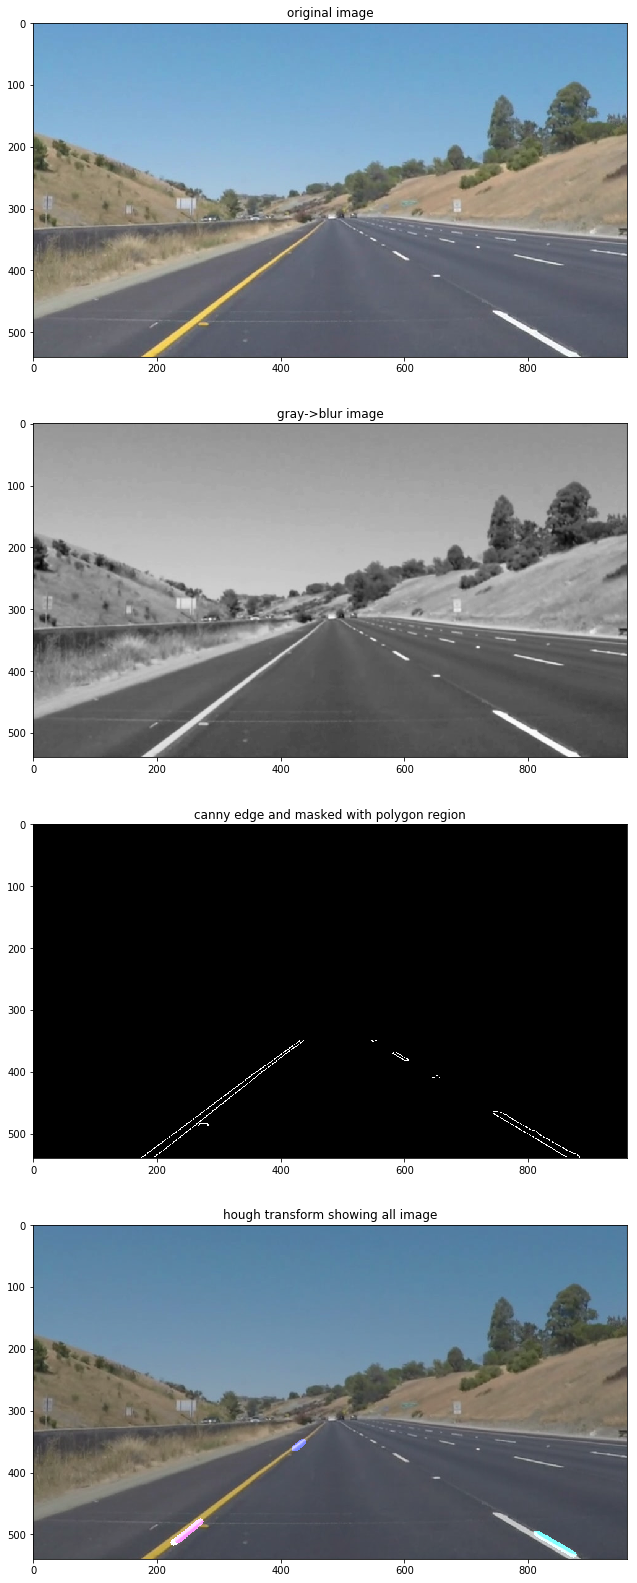

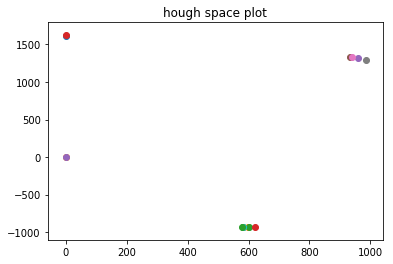

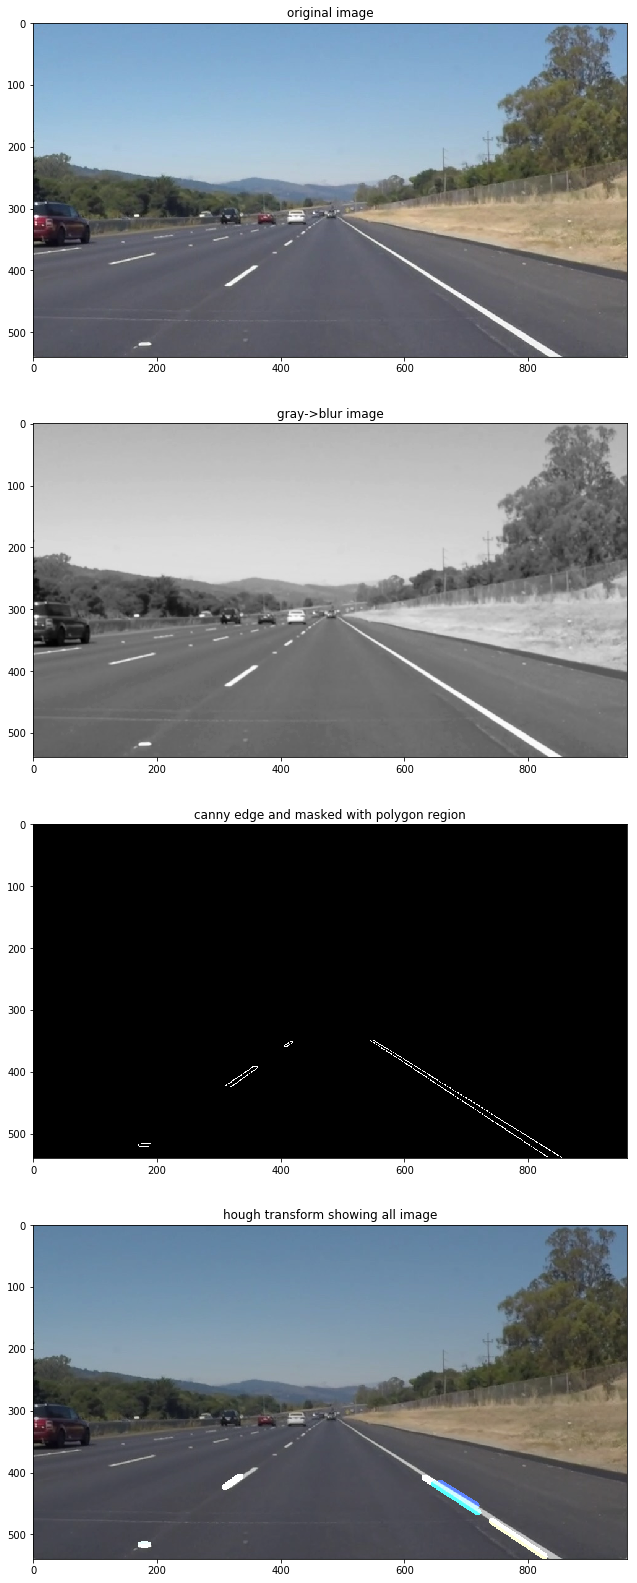

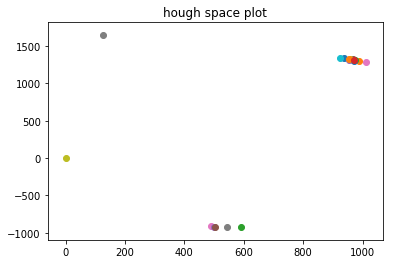

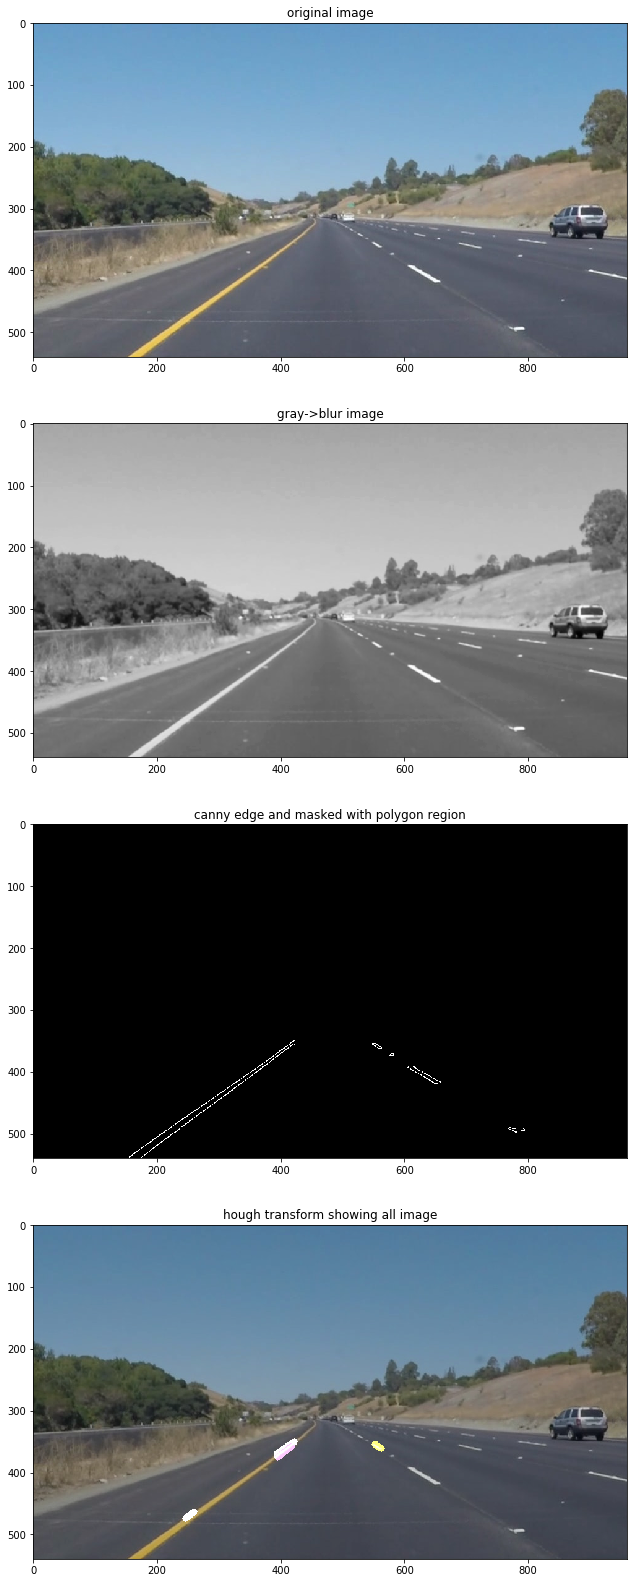

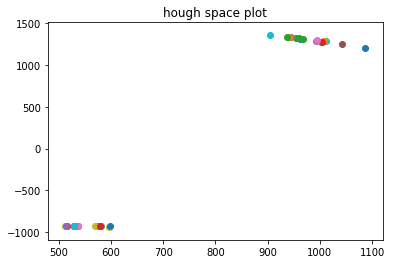

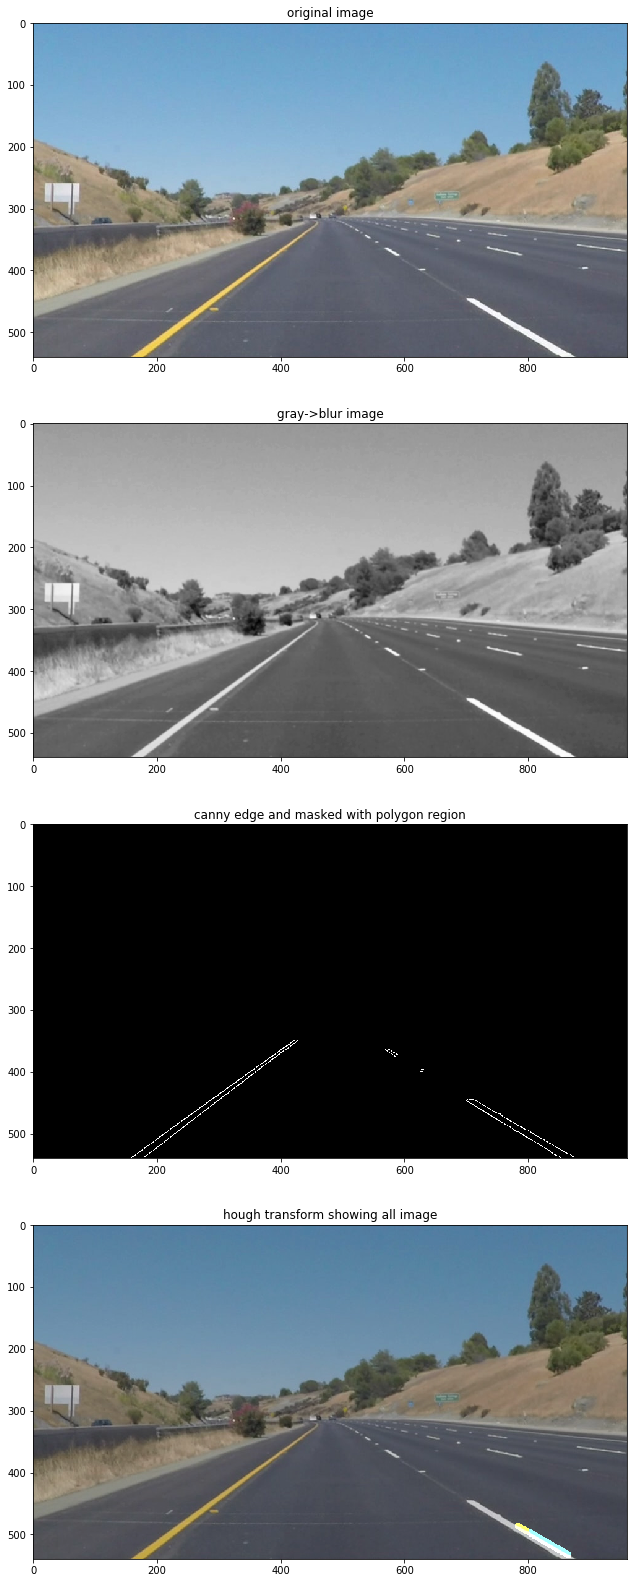

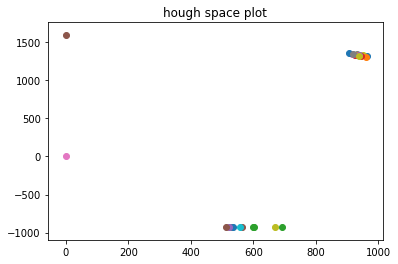

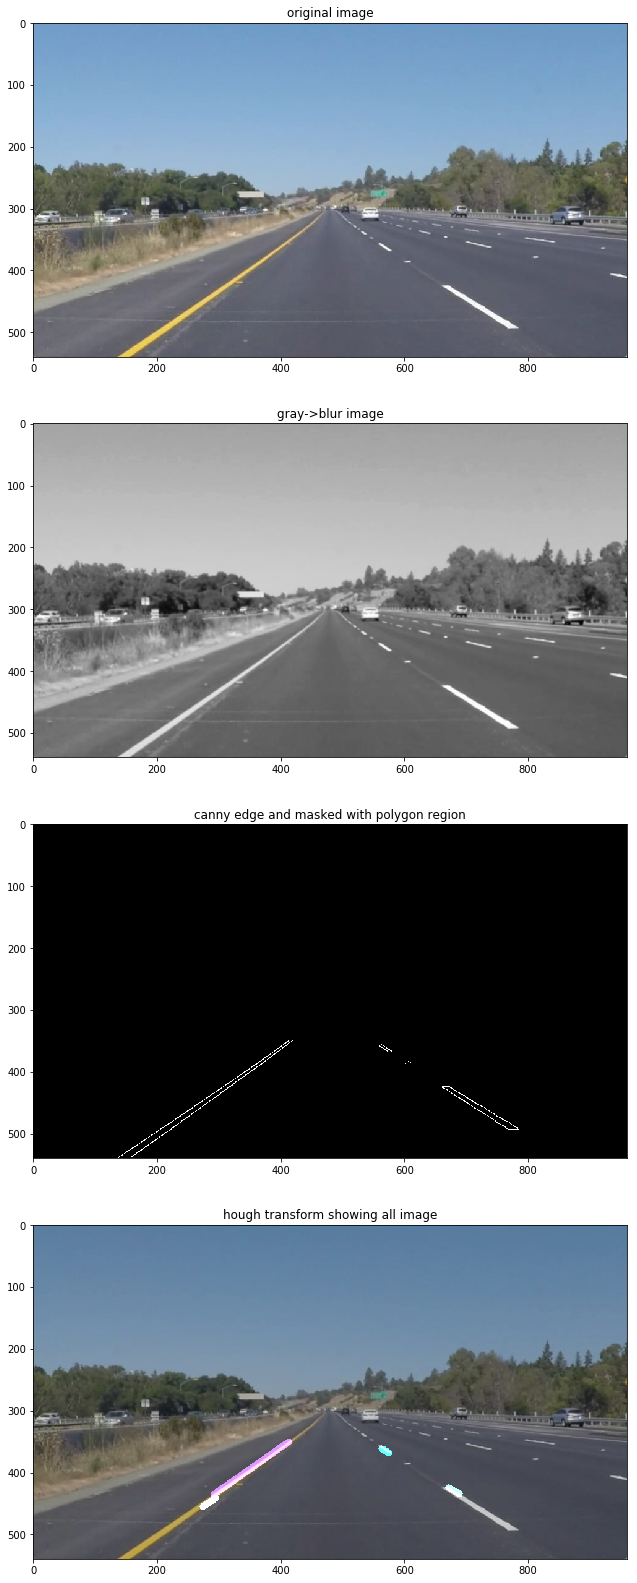

In [154]:
# 
# Basic image processing techniques
#reading in an image 
# complication when using cv2.imread(), use BGR instead of RGB

use_video = False
use_hough_cluster = False
if (not use_video):
    file = os.listdir("test_images/")
#     print("os function:",np.array(file).shape,file)
    for file_name in file:
        file_name = 'test_images/' + file_name
        image = mpimg.imread(file_name)
        
        process_image(image,use_hough_cluster,use_video)
        cv2.waitKey(0)

if (use_video):
#     uncomment each block to test the result( challange_output is detection result error in some frames)
    white_output = 'test_videos_output/solidWhiteRight.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
    white_clip = clip1.fl_image(lambda image: process_image(image,use_hough_cluster,use_video)) #NOTE: this function expects color images!!, use lambda function to add more argument
    %time white_clip.write_videofile(white_output, audio=False)
    
#     yellow_output = 'test_videos_output/solidYellowLeft.mp4'
#     ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
#     ## To do so add .subclip(start_second,end_second) to the end of the line below
#     ## Where start_second and end_second are integer values representing the start and end of the subclip
#     ## You may also uncomment the following line for a subclip of the first 5 seconds
#     ##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#     clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
#     yellow_clip = clip2.fl_image(lambda image: process_image(image,use_hough_cluster,use_video))
#     %time yellow_clip.write_videofile(yellow_output, audio=False)

#     challenge_output = 'test_videos_output/challenge.mp4'
#     ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
#     ## To do so add .subclip(start_second,end_second) to the end of the line below
#     ## Where start_second and end_second are integer values representing the start and end of the subclip
#     ## You may also uncomment the following line for a subclip of the first 5 seconds
#     ##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
#     clip3 = VideoFileClip('test_videos/challenge.mp4')
#     challenge_clip = clip3.fl_image(lambda image: process_image(image,use_hough_cluster,use_video))
#     %time challenge_clip.write_videofile(challenge_output, audio=False)


# blur_gray = gaussianMask(gray,1)
# edges = canny(blur_gray,150,300)
# # print(type(edges), edges.shape, "edges", edges)
# [masked_edges,polygon_vertices] = polygon_regionMask(edges,0.5,80)
# hough_lines = hough(masked_edges,1,1,10,10,1)
# hough_lines = find_intersection(polygon_vertices,hough_lines)
# line_image = create_line_image(image,hough_lines)
# # mono_line = hough(masked_edges,1,1,10,10,1)[1]
# # second_hough_image = hough(mono_line,1,1,10,10,1)[0]
# # print(mono_line.shape,edges.shape, "shape",type(mono_line), type(edges) )
# # plt.imshow(mono_line,cmap = "gray")
# # plt.imshow(second_hough_image)
# combine_image = cv2.addWeighted(image,0.8,line_image,0.8,0)


In [398]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))